# init

In [3]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS
from rasterio.plot import show

#from shapely.geometry import mapping
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [4]:
def getFeatures(gdf):
    #Function to parse features from GeoDataFrame in such a manner that rasterio wants them
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

#def reproject_raster(in_path, out_path):

   

In [ ]:
# this function reprojets a raster to the CRS of a given shapefile
# note that the ressampling might create a very large file

def reproject_raster(in_raster, AOI_CRS):
    from rasterio.warp import calculate_default_transform
    from rasterio.warp import reproject
    from rasterio.enums import Resampling
    # code from https://pygis.io/docs/e_raster_reproject.html

    dst_crs = AOI_CRS 
    src = in_raster

    src_transform = src.transform

        # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

    # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  # replace 0 with np.nan
        }
    )

    with rasterio.open("../data/processed/reprojected_raster.tif", "w", **dst_kwargs) as dst:
            # iterate through bands
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )
    

# input

In [33]:
#input a vector and a raster file
raster_path = Path(r'D:\\Dropbox\\x\\_data\\WD Sentinel NDVI via Gee\\')
raster_file = 'ENV_RSFL24_NDVI_Sentinel_2024.tif'
in_raster = rasterio.open(raster_path/raster_file, 'r+') # note that the raster and AOI must be in the same CRS, if not, the vector will be reprojected

AOI_path = Path('../data/processed/')
AOI_file = 'LIM_RS_RMPA_2023_A.shp'

AOI_gdf = gpd.read_file(AOI_path/AOI_file)
AOI_CRS = CRS.from_string(AOI_gdf.crs.to_string())

if AOI_CRS != in_raster.crs:
    AOI_gdf = AOI_gdf.to_crs(in_raster.crs)

#get the coordinates of the AOI
AOI_geom = AOI_gdf.envelope #[AOI_gdf['nome']== 'Taquari-Antas']
#coords = getFeatures(AOI_gdf)

print('AOI:', AOI_gdf.crs.to_epsg(),'Raster:', in_raster.crs.to_epsg())

AOI: 4326 Raster: 4326


In [34]:
clipped_array, clipped_transform = mask(dataset=in_raster, shapes=AOI_geom, crop=True)

In [35]:
#setting up the output file
out_path = Path('../data/processed/')
out_file = 'ENV_NDVI_Sentinel_2024_clipped_RMPA.tif'
out_url = out_path/out_file

AOI_gdf = AOI_gdf.to_crs(in_raster.crs)
out_meta = in_raster.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": clipped_array.shape[1],
                 "width": clipped_array.shape[2],
                 "transform": clipped_transform})

with rasterio.open(out_url, "w", **out_meta) as dest:
    dest.write(clipped_array)

(-52.15879051030336,
 -50.372400736303284,
 -30.637941080180404,
 -29.470221042353437)

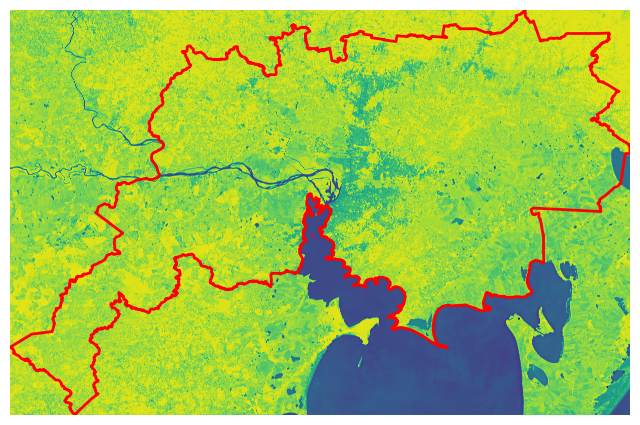

In [36]:
#plotting to be sure it worked
clipped = rasterio.open(out_url)
fig, ax = plt.subplots(figsize=(8, 6))
p1 = AOI_gdf.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(clipped, ax=ax)
ax.axis('off')